In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import itertools
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import keras.layers as lyr
from keras.models import Model

import xgboost as xgb

In [6]:
BASE_DIR = './dataset/'
train = pd.read_csv(f'{BASE_DIR}train.csv')
test = pd.read_csv(f'{BASE_DIR}test.csv')
# train = pd.read_csv(f'{BASE_DIR}train_preprocessed.csv')

In [7]:
train['id'] = train['id'].apply(str)
test['test_id'] = test['test_id'].apply(str)

In [8]:
df = pd.concat((train, test))
# df = train
df['question1'].fillna('', inplace=True)
df['question2'].fillna('', inplace=True)

### Vocab

In [9]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(
        df['question1'], 
        df['question2']
        )
    )
other_index = len(counts_vectorizer.vocabulary_)

In [10]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [11]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(
        lambda s: 
            [
                counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
                for w in words_tokenizer.findall(s.lower())
            ]
        )
    return pad_sequences(seqs, maxlen=max_len)

In [12]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(
        create_padded_seqs(df[df['id'].notnull()]['question1']), 
        create_padded_seqs(df[df['id'].notnull()]['question2']),
        df[df['id'].notnull()]['is_duplicate'].values,
        stratify=df[df['id'].notnull()]['is_duplicate'].values,
        test_size=0.3, random_state=1989
    )
X1_val, X1_test, X2_val, X2_test, y_val, y_test = \
    train_test_split(
        X1_val, 
        X2_val,
        y_val,
        stratify=y_val,
        test_size=0.5, random_state=1989
    )

In [13]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

# dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
# ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

# model = Model([input1_tensor, input2_tensor], ouput_layer)

# model.compile(loss='binary_crossentropy', optimizer='adam')
# model.summary()

In [ ]:
# model.fit([X1_train, X2_train], y_train, 
#           validation_data=([X1_val, X2_val], y_val), 
#           batch_size=128, epochs=6, verbose=2)

In [14]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')
F_train = features_model.predict([X1_train, X2_train], batch_size=128)
F_val = features_model.predict([X1_val, X2_val], batch_size=128)

In [15]:
import pickle
pickle.dump(merge_layer, open("./models/analysis2/merge_layer_unprocessed.pkl", "wb"))

### XgBoost on top

In [16]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}

In [17]:
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')],
                verbose_eval=10, early_stopping_rounds=10)


[15:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67954	val-logloss:0.68054
[10]	train-logloss:0.60924	val-logloss:0.61783
[20]	train-logloss:0.57928	val-logloss:0.59478
[30]	train-logloss:0.56041	val-logloss:0.58232
[40]	train-logloss:0.54551	val-logloss:0.57386
[50]	train-logloss:0.53390	val-logloss:0.56806
[60]	train-logloss:0.52326	val-logloss:0.56331
[70]	train-logloss:0.51404	val-logloss:0.55969
[80]	train-logloss:0.50502	val-logloss:0.55628
[90]	train-logloss:0.49600	val-logloss:0.55318
[100]	train-logloss:0.48787	val-logloss:0.55078
[110]	train-logloss:0.48027	val-logloss:0.54855
[120]	train-logloss:

In [18]:
pickle.dump(bst, open("./models/analysis2/xgb_unprocessed.pkl", "wb"))

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,test_id
0,0,1.0,2.0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0,NaN
1,1,3.0,4.0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.0,NaN
2,2,5.0,6.0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.0,NaN
3,3,7.0,8.0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.0,NaN
4,4,9.0,10.0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.0,NaN


In [20]:
F_test = features_model.predict([X1_test, X2_test], batch_size=128)

In [21]:
dTest = xgb.DMatrix(F_test)

In [22]:
df_sub = pd.DataFrame({
        'is_duplicate_true': y_test,
        'is_duplicate_pred': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    })

df_sub.head()

d:\college\Sem_5\NLP\Project\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,is_duplicate_true,is_duplicate_pred
0,0.0,0.504413
1,0.0,0.082391
2,0.0,0.154923
3,1.0,0.237311
4,0.0,0.297524


<AxesSubplot:>

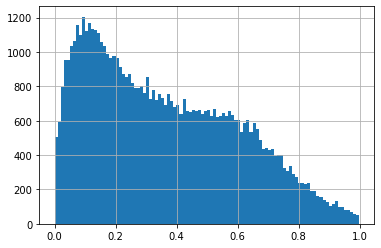

In [24]:
df_sub['is_duplicate_pred'].hist(bins=100)

In [26]:
df_sub['is_duplicate_pred'] = df_sub['is_duplicate_pred'].apply(lambda x : 1 if x>0.5 else 0)

In [27]:
y_pred = bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
y_pred = np.where(y_pred>0.5, 1, 0)

d:\college\Sem_5\NLP\Project\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [28]:
accuracy_score(y_test, y_pred)

0.742414748367522

In [29]:
confusion_matrix(y_test, y_pred)

array([[32630,  5624],
       [ 9997, 12393]], dtype=int64)

In [30]:
f1_score(y_test, y_pred)

0.613408567822407

### XGBClassifier

In [31]:
classifier1 = xgb.XGBClassifier(
    max_depth=50, 
    n_estimators=80, ## number of boosting rounds
    learning_rate=0.1, 
    colsample_bytree=.7, ## Subsample ratio of columns when constructing each tree.
    gamma=0, ##  Minimum loss reduction required to make a further partition on a leaf node of the tree.
    reg_alpha=4, ##  L1 regularization term on weights
    objective='binary:logistic', 
    subsample=0.8, ## Subsample ratio of the training instance.
)
classifier1.fit(F_train, y_train)


[16:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
classifier1.fit(F_test, y_test)

In [1]:
import pickle

bst = pickle.load(open("./models/analysis2/xgb_unprocessed.pkl", "rb"))


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

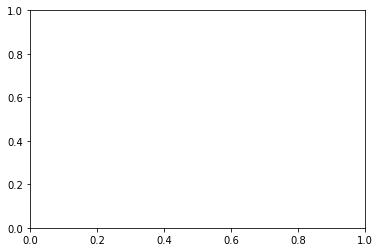

In [2]:
import xgboost as xgb
xgb.plot_tree(bst, num_trees=2)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1440x720 with 0 Axes>

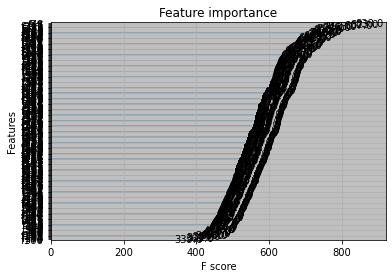

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
xgb.plot_importance(bst)
